In [11]:
import environments
import numpy as np
from collections import deque
import library as lib
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
env1 = environments.environment_gym('Acrobot-v1')
env = environments.env_wrapper(env1)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [13]:
n_action = env.action_size()

In [14]:
from collections import namedtuple, deque
import random
import torch
import numpy as np

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
  
        return (states, actions, rewards, next_states, dones)
  

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [15]:
def store(env, n_episodes, replaybuffer, window = 100):
    scores = []
    moving_scores = deque(maxlen = window)
    moving_average_scores = []
    for i_epsiodes in range(0,n_episodes):
        print('\r','Episode [{}/{}]'.format(i_epsiodes, n_episodes),end='')
        done = False
        state = env.reset()
        score = 0
        while not done:
            next_action = env.env.action_space_sample()
            next_state, reward, done, _ = env.step(next_action)
            score+=reward
            replaybuffer.add(state,next_action, reward, next_state, done)
            state = next_state
        scores.append(score)
        moving_scores.append(score)
        moving_average_scores.append(np.mean(moving_scores))
    return np.mean(scores), scores, moving_average_scores, replaybuffer

In [16]:
rb = ReplayBuffer(action_size = n_action,buffer_size = 100,batch_size = 10,seed = 12345)

Episode [14/15]max -500.0


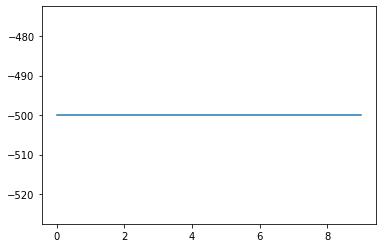

In [17]:

#random policy
#policy = lib.random()
#Q = defaultdict(lambda: np.zeros(n_actions))
mean_scores, score, moving_window, rb = store(env, 15,rb)
moving_window = moving_window[5:]
print('max',max(moving_window))
plt.plot(moving_window)
plt.show()

In [18]:
rb.sample()

(array([[ 0.78031613, -0.62538527,  0.72024213, -0.69372277, -0.15876221,
          0.71501991],
        [ 0.70445026, -0.70975336,  0.80862836, -0.58831979,  1.06737054,
         -2.01975888],
        [ 0.97388726,  0.22703218,  0.98190139,  0.18939286, -1.07035893,
          3.9809933 ],
        [ 0.99371   , -0.11198412,  0.87725251,  0.48002919, -0.67966763,
          3.80784709],
        [ 0.96092397,  0.27681243,  0.9569996 ,  0.29008925,  0.16631193,
         -3.419415  ],
        [ 0.78677825,  0.61723577,  0.97534464,  0.2206872 , -0.63448649,
          0.6080165 ],
        [ 0.99500197,  0.09985531, -0.19008359, -0.98176791,  0.63060884,
          0.30619886],
        [ 0.92096728,  0.38963993, -0.84047527, -0.54184991,  0.01609697,
         -0.86135173],
        [ 0.87416859, -0.48562256,  0.90744423, -0.42017254,  0.98014809,
          0.85005897],
        [ 0.99679522,  0.07999554,  0.95028506,  0.31138129,  1.58803965,
         -0.28175403]]), array([[2],
        [2],
   

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
class LinearModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(state_size, action_size)

    def forward(self,x):
        return self.linear(x)

In [43]:
model = LinearModel(env.env.observation_space().shape[0],env.action_size())

In [50]:
model(torch.tensor(env.reset()).float())

tensor([-0.7716,  0.1688, -0.2240], grad_fn=<AddBackward0>)

In [88]:
from collections import namedtuple, deque
import random
import torch
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

class Agent():
    def __init__(self, state_size, action_size, seed=122334):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # model definition
        self.model_local = LinearModel(state_size, action_size)
        self.model_target = LinearModel(state_size, action_size)
        self.optimizer = optim.Adam(self.model_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.model_local.eval()
        with torch.no_grad():
            action_values = self.model_local(state)
        self.model_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        next_states = torch.tensor(next_states).float()
        rewards = torch.tensor(rewards).float()
        actions = torch.tensor(actions).long()
        states = torch.tensor(states).float()
        dones = torch.tensor(dones).float()
            # Get max predicted Q values (for next states) from target model (without ddqn)
        Q_targets_next = self.model_target(next_states).detach().max(1)[0].unsqueeze(1)
    
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.model_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network 
        self.soft_update(self.model_local, self.model_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [89]:
agent = Agent(env.env.observation_space().shape[0],env.action_size())

In [90]:
max_t = 100
for i_episode in range(0,10):
    state = env.reset()
    for t in range(0,max_t):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        if done:
            break

In [59]:
#need to instroduce 1. a scoring mechanism, 2. 

array([ 0.99870692,  0.05083794,  0.99868278, -0.05130988, -0.01400417,
        0.09323692])